# 3-dimensional tight-binding model for SnTe with spin-orbit interaction

The basis chosen is: 

$$|\Psi\rangle = \left\{
|\psi_{p_x,\uparrow}^\text{Sn} \rangle,
|\psi_{p_x,\downarrow}^\text{Sn} \rangle,
|\psi_{p_y,\uparrow}^\text{Sn} \rangle,
|\psi_{p_y,\downarrow}^\text{Sn} \rangle,
|\psi_{p_z,\uparrow}^\text{Sn} \rangle,
|\psi_{p_z,\downarrow}^\text{Sn} \rangle,
|\psi_{p_x,\uparrow}^\text{Te} \rangle,
|\psi_{p_x,\downarrow}^\text{Te} \rangle,
|\psi_{p_y,\uparrow}^\text{Te} \rangle,
|\psi_{p_y,\downarrow}^\text{Te} \rangle,
|\psi_{p_z,\uparrow}^\text{Te} \rangle,
|\psi_{p_z,\downarrow}^\text{Te} \rangle\right\}$$.

In [1]:
import numpy as np
import qsymm
import math
from scipy.linalg import block_diag
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Pauli matrices and the like
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])
zeros = np.zeros((2,2))

# Spin-orbit interaction matrix
soc_1 = np.hstack((zeros,sigma_z,-sigma_y))
soc_2 = np.hstack((-sigma_z, zeros, sigma_x))
soc_3 = np.hstack((sigma_y, -sigma_x, zeros))
soc = np.vstack((soc_1, soc_2, soc_3))

# Hamiltonian with spin-orbit interaction
def ham(kx, ky, kz, m, tSn, tTe, t, a, lambdaSn, lambdaTe):
    ham_Sn_Te = [
        [-m + 2*tSn*math.cos(kx*a/2)*(math.cos(ky*a/2) + math.cos(kz*a/2)), -2*tSn*math.sin(kx*a/2)*math.sin(ky*a/2), -2*tSn*math.sin(kx*a/2)*math.sin(kz*a/2), 2*t*math.cos(kx*a/2), 0, 0],
        [-2*tSn*math.sin(ky*a/2)*math.sin(kx*a/2), -m + 2*tSn*math.cos(ky*a/2)*(math.cos(kx*a/2) + math.cos(kz*a/2)), -2*tSn*math.sin(ky*a/2)*math.sin(kz*a/2), 0, 2*t*math.cos(ky*a/2), 0],
        [-2*tSn*math.sin(kx*a/2)*math.sin(kz*a/2), -2*tSn*math.sin(ky*a/2)*math.sin(kz*a/2), -m + 2*tSn*math.cos(kz*a/2)*(math.cos(kx*a/2) + math.cos(ky*a/2)), 0, 0, 2*t*math.cos(kz*a/2)],
        [2*t*math.cos(kx*a/2), 0, 0, m + 2*tTe*math.cos(kx*a/2)*(math.cos(ky*a/2) + math.cos(kz*a/2)), -2*tTe*math.sin(kx*a/2)*math.sin(ky*a/2), -2*tTe*math.sin(kx*a/2)*math.sin(kz*a/2)],
        [0, 2*t*math.cos(ky*a/2), 0, -2*tTe*math.sin(kx*a/2)*math.sin(ky*a/2), m + 2*tTe*math.cos(kx*a/2)*(math.cos(ky*a/2) + math.cos(kz*a/2)), -2*tTe*math.sin(ky*a/2)*math.sin(kz*a/2)],
        [0, 0, 2*t*math.cos(kz*a/2), -2*tTe*math.sin(kx*a/2)*math.sin(kz*a/2), -2*tTe*math.sin(ky*a/2)*math.sin(kz*a/2), m + 2*tTe*math.cos(kz*a/2)*(math.cos(kx*a/2) + math.cos(ky*a/2))]] 
    ham = np.kron(ham_Sn_Te, np.eye(2))
    ham_SOC = np.kron([[lambdaSn, 0], [0, lambdaTe]], soc)*-1j # We believe that it should be -1j, is what we observe in literature
    return np.add(ham, ham_SOC)
    #return ham_Sn_Te
    #return ham_SOC
    #return soc

matrixsize = len(ham(0,0,0,0,0,0,0,0,0,0)) # Size of the basis

#print((ham(0,0,0,1,0,0,0,1,0,0)))

## k-points high symmetry points
We implement the following sequence of high symmetry points

$$
\Gamma - X - W - L - \Gamma - K
$$
which describes the points on a FCC Brillouin zone. For simplicity, we assume that they are equally spaced.

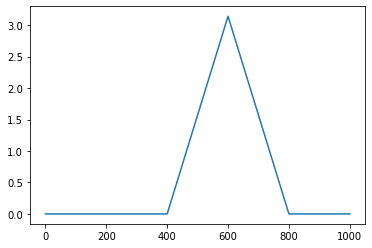

In [42]:
stepsize = 200
hsp = 5 # Number of high symmetry points

kx_array = np.zeros(hsp*stepsize + 1)
for i in range(stepsize):
    kx_GX = 0
    kx_XW = i*np.pi/(stepsize)
    kx_WL = np.pi
    kx_LG = (stepsize - i)*np.pi/(stepsize)
    kx_GK = i*3/2*np.pi/(stepsize)
    kx_array[i] = kx_GX
    kx_array[i + stepsize] = kx_XW
    kx_array[i + 2*stepsize] = kx_WL
    kx_array[i + 3*stepsize] = kx_LG
    kx_array[i + 4*stepsize] = kx_GK
    kx_array[5*stepsize] = 3/2*np.pi
        
ky_array = np.zeros(hsp*stepsize + 1)
for i in range(stepsize):
    ky_GX = 2*i*np.pi/(stepsize)
    ky_XW = 2*np.pi
    ky_WL = (stepsize - i/2)*2*np.pi/(stepsize)
    ky_LG = (stepsize - i)*np.pi/(stepsize)
    ky_GK = i*3/2*np.pi/(stepsize)
    ky_array[i] = ky_GX
    ky_array[i + stepsize] = ky_XW
    ky_array[i + 2*stepsize] = ky_WL
    ky_array[i + 3*stepsize] = ky_LG
    ky_array[i + 4*stepsize] = ky_GK
    ky_array[5*stepsize] = 3/2*np.pi

kz_array = np.zeros(hsp*stepsize + 1)
for i in range(stepsize):
    kz_WL = i*np.pi/(stepsize)
    kz_LG = (stepsize - i)*np.pi/(stepsize)
    kz_array[i + 2*stepsize] = kz_WL
    kz_array[i + 3*stepsize] = kz_LG

k_array = np.zeros(hsp*stepsize + 1)
for i in range(hsp*stepsize + 1):
    k_array[i] = i
    
plt.plot(k_array, kz_array)
plt.show()

## k-points high symmetry points (rescaled)
We implement the following sequence of high symmetry points

$$
\Gamma - X - W - L - \Gamma - K
$$
which describes the points on a FCC Brillouin zone. Now we scale the k-points with the distance between two high symmetry points

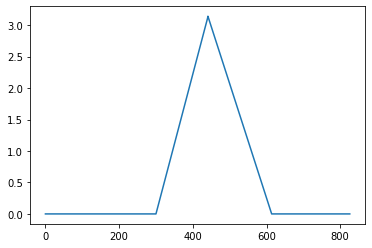

In [46]:
stepsize = 200
hsp = 5 # Number of high symmetry points
hsp_rel = 1 + 1/2 + 1/np.sqrt(2) + np.sqrt(3)/2 + 3/np.sqrt(2)/2

############################################## kx

kx_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(stepsize):
    kx_GX = 0
    kx_array[i] = kx_GX
    
for i in range(int(stepsize/2)):
    kx_XW = i*np.pi/(stepsize/2)
    kx_array[i + stepsize] = kx_XW
    
for i in range(int(stepsize/np.sqrt(2))):
    kx_WL = np.pi
    kx_array[i + int(3/2*stepsize)] = kx_WL
    
for i in range(int(stepsize/2*np.sqrt(3))):
    kx_LG = (stepsize/2*np.sqrt(3) - i)*np.pi/(stepsize/2*np.sqrt(3))
    kx_array[i + int((3/2 + 1/np.sqrt(2))*stepsize)] = kx_LG
    
for i in range(int(3*stepsize/(np.sqrt(2)*2))):
    kx_GK = i*3/2*np.pi/((stepsize)/(2*np.sqrt(2)/3))
    kx_array[i + int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)] = kx_GK
kx_array[-1] = 3/2*np.pi

############################################## ky

ky_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(stepsize):
    ky_GX = 2*i*np.pi/(stepsize)
    ky_array[i] = ky_GX
    
for i in range(int(stepsize/2)):
    ky_XW = 2*np.pi
    ky_array[i + stepsize] = ky_XW
    
for i in range(int(stepsize/np.sqrt(2))):
    ky_WL = (stepsize/np.sqrt(2) - i/2)*2*np.pi/(stepsize/np.sqrt(2))
    ky_array[i + int(3/2*stepsize)] = ky_WL

for i in range(int(stepsize/2*np.sqrt(3))):
    ky_LG = (stepsize/2*np.sqrt(3) - i)*np.pi/(stepsize/2*np.sqrt(3))
    ky_array[i + int((3/2 + 1/np.sqrt(2))*stepsize)] = ky_LG
    
for i in range(int(3*stepsize/(np.sqrt(2)*2))):
    ky_GK = i*3/2*np.pi/((stepsize)/(2*np.sqrt(2)/3))
    ky_array[i + int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)] = ky_GK    
ky_array[-1] = 3/2*np.pi
    
    
######################################### kz

kz_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(int(stepsize/np.sqrt(2))):
    kz_WL = i*np.pi/(stepsize/np.sqrt(2))
    kz_array[i + int(3/2*stepsize)] = kz_WL
    
for i in range(int(stepsize/2*np.sqrt(3))):
    kz_LG = (stepsize/2*np.sqrt(3) - i)*np.pi/(stepsize/2*np.sqrt(3))
    kz_array[i + int((3/2 + 1/np.sqrt(2))*stepsize)] = kz_LG

####################################### k_array 
    
k_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(int(hsp_rel*stepsize) + 1):
    k_array[i] = i

plt.plot(k_array, kz_array)
plt.show()

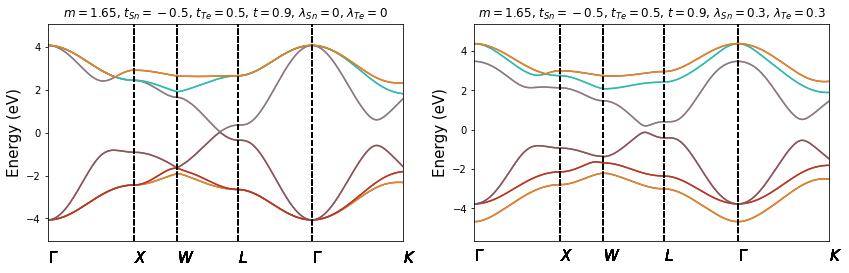

In [59]:
# Model parameters, first plot
# To turn off SOC, set lambda_Sn and lambda_Te to zero
m = 1.65
tSn = -0.5
tTe = 0.5
t = 0.9
a = 1
lambdaSn = 0
lambdaTe = 0

# Generate the energy bands from diagonalizing the aforementioned Hamiltonion
energies = np.zeros((matrixsize, int(hsp_rel*stepsize + 1)))
for i in range(int(hsp_rel*stepsize + 1)):
    kx = kx_array[i]
    ky = ky_array[i]
    kz = kz_array[i]
    for j in range(matrixsize):
        energies[j][i] = LA.eigvalsh(ham(kx, ky, kz, m, tSn, tTe, t, a, lambdaSn, lambdaTe))[j]

# The k-axis
k_array = np.zeros(int(hsp_rel*stepsize + 1))
for i in range(int(hsp_rel*stepsize + 1)):
    k_array[i] = i

# Dashed vertial lines for high symmetry points  
minimum = np.min(energies) 
maximum = np.max(energies)
_list = [minimum - 1, maximum + 1]        

X = int(stepsize)
X_list = np.ones(2)*X
W = int(stepsize*3/2)
W_list = np.ones(2)*W
L = int((3/2 + 1/np.sqrt(2))*stepsize)
L_list = np.ones(2)*L
G = int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)
G_list = np.ones(2)*G



# Generate the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))
#fig.suptitle('With phase factor between hoppings of same unit cell', fontsize = 15)

for i in range(matrixsize):
    ax1.plot(k_array, energies[i])
    ax1.set_ylabel(r"Energy (eV)", fontsize = 15)
    ax1.set_xlim(0, max(k_array))
    ax1.set_ylim(np.min(energies) - 1,np.max(energies) + 1)
    ax1.set_xticks([])
    ax1.text(0, minimum - 2, '$\Gamma$', fontsize = 15)
    ax1.text(k_array[int(stepsize)], minimum - 2, '$X$', fontsize = 15)
    ax1.text(k_array[int(stepsize*3/2)], minimum - 2, '$W$', fontsize = 15)
    ax1.text(k_array[int((3/2 + 1/np.sqrt(2))*stepsize)], minimum - 2, '$L$', fontsize = 15)
    ax1.text(k_array[int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)], minimum - 2, '$\Gamma$', fontsize = 15)
    ax1.text(k_array[len(k_array) - 1], minimum - 2, '$K$', fontsize = 15)
    ax1.plot(X_list, _list, color = 'black', linestyle = 'dashed')
    ax1.plot(W_list, _list, color = 'black', linestyle = 'dashed')
    ax1.plot(L_list, _list, color = 'black', linestyle = 'dashed')
    ax1.plot(G_list, _list, color = 'black', linestyle = 'dashed')
    ax1.set_title(
        r'$m = %g$, $t_{Sn} = %g$, $t_{Te} = %g$, $t = %g$, $\lambda_{Sn} = %g$, $\lambda_{Te} = %g$' % (
            m, tSn, tTe, t, lambdaSn, lambdaTe), fontsize = 12)

####################################################################### Second plot

# Model parameters, second plot
# To turn off SOC, set lambdaSn and lambdaTe to zero
m = 1.65
tSn = -0.5
tTe = 0.5
t = 0.9
a = 1
lambdaSn = 0.3
lambdaTe = 0.3

# Generate the energy bands from diagonalizing the aforementioned Hamiltonion
energies = np.zeros((matrixsize, int(hsp_rel*stepsize + 1)))
for i in range(int(hsp_rel*stepsize + 1)):
    kx = kx_array[i]
    ky = ky_array[i]
    kz = kz_array[i]
    for j in range(matrixsize):
        energies[j][i] = LA.eigvalsh(ham(kx, ky, kz, m, tSn, tTe, t, a, lambdaSn,lambdaTe))[j]    

# Dashed vertial lines for high symmetry points  
minimum = np.min(energies) 
maximum = np.max(energies)
_list = [minimum - 1, maximum + 1]     
    
for i in range(matrixsize):
    ax2.plot(k_array, energies[i])
    ax2.set_ylabel(r"Energy (eV)", fontsize = 15)
    ax2.set_xlim(0, max(k_array))
    ax2.set_ylim(np.min(energies) - 1,np.max(energies) + 1)
    ax2.set_xticks([])
    ax2.text(0, minimum - 2, '$\Gamma$', fontsize = 15)
    ax2.text(k_array[int(stepsize)], minimum - 2, '$X$', fontsize = 15)
    ax2.text(k_array[int(stepsize*3/2)], minimum - 2, '$W$', fontsize = 15)
    ax2.text(k_array[int((3/2 + 1/np.sqrt(2))*stepsize)], minimum - 2, '$L$', fontsize = 15)
    ax2.text(k_array[int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)], minimum - 2, '$\Gamma$', fontsize = 15)
    ax2.text(k_array[len(k_array) - 1], minimum - 2, '$K$', fontsize = 15)
    ax2.plot(X_list, _list, color = 'black', linestyle = 'dashed')
    ax2.plot(W_list, _list, color = 'black', linestyle = 'dashed')
    ax2.plot(L_list, _list, color = 'black', linestyle = 'dashed')
    ax2.plot(G_list, _list, color = 'black', linestyle = 'dashed')
    ax2.set_title(
        r'$m = %g$, $t_{Sn} = %g$, $t_{Te} = %g$, $t = %g$, $\lambda_{Sn} = %g$, $\lambda_{Te} = %g$' % (
            m, tSn, tTe, t, lambdaSn, lambdaTe), fontsize = 12)

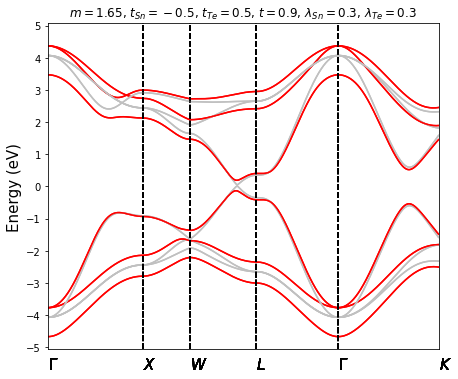

In [71]:
# Model parameters, first plot
# To turn off SOC, set lambda_Sn and lambda_Te to zero
m = 1.65
tSn = -0.5
tTe = 0.5
t = 0.9
a = 1
lambdaSn = 0
lambdaTe = 0

# Generate the plot
fig = plt.figure(figsize = (7,6))

# Generate the energy bands from diagonalizing the aforementioned Hamiltonion w/o SOC
energies_noSOC = np.zeros((matrixsize, int(hsp_rel*stepsize + 1)))
for i in range(int(hsp_rel*stepsize + 1)):
    kx = kx_array[i]
    ky = ky_array[i]
    kz = kz_array[i]
    for j in range(matrixsize):
        energies_noSOC[j][i] = LA.eigvalsh(ham(kx, ky, kz, m, tSn, tTe, t, a, lambdaSn, lambdaTe))[j]
        
lambdaSn = 0.3
lambdaTe = 0.3

# Generate the energy bands from diagonalizing the aforementioned Hamiltonion w SOC
energies_SOC = np.zeros((matrixsize, int(hsp_rel*stepsize + 1)))
for i in range(int(hsp_rel*stepsize + 1)):
    kx = kx_array[i]
    ky = ky_array[i]
    kz = kz_array[i]
    for j in range(matrixsize):
        energies_SOC[j][i] = LA.eigvalsh(ham(kx, ky, kz, m, tSn, tTe, t, a, lambdaSn, lambdaTe))[j]
        
# The k-axis
k_array = np.zeros(int(hsp_rel*stepsize + 1))
for i in range(int(hsp_rel*stepsize + 1)):
    k_array[i] = i

# Dashed vertial lines for high symmetry points  
minimum = np.min(energies_noSOC) 
maximum = np.max(energies_noSOC)
_list = [minimum - 1, maximum + 1]
X = int(stepsize)
X_list = np.ones(2)*X
W = int(stepsize*3/2)
W_list = np.ones(2)*W
L = int((3/2 + 1/np.sqrt(2))*stepsize)
L_list = np.ones(2)*L
G = int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)
G_list = np.ones(2)*G


for i in range(matrixsize):
    plt.plot(k_array, energies_noSOC[i], 'silver')
    plt.plot(k_array, energies_SOC[i], 'red')
    plt.ylabel(r"Energy (eV)", fontsize = 15)
    plt.xlim(0, max(k_array))
    plt.ylim(np.min(energies_noSOC) - 1,np.max(energies_noSOC) + 1)
    plt.xticks([])
    plt.yticks(np.arange(-5, 5.5, 1))   
    plt.text(0, minimum - 1.6, '$\Gamma$', fontsize = 15)
    plt.text(k_array[int(stepsize)], minimum - 1.6, '$X$', fontsize = 15)
    plt.text(k_array[int(stepsize*3/2)], minimum - 1.6, '$W$', fontsize = 15)
    plt.text(k_array[int((3/2 + 1/np.sqrt(2))*stepsize)], minimum - 1.6, '$L$', fontsize = 15)
    plt.text(k_array[int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)], minimum - 1.6, '$\Gamma$', fontsize = 15)
    plt.text(k_array[len(k_array) - 1], minimum - 1.6, '$K$', fontsize = 15)
    plt.plot(X_list, _list, color = 'black', linestyle = 'dashed')
    plt.plot(W_list, _list, color = 'black', linestyle = 'dashed')
    plt.plot(L_list, _list, color = 'black', linestyle = 'dashed')
    plt.plot(G_list, _list, color = 'black', linestyle = 'dashed')
    plt.title(
        r'$m = %g$, $t_{Sn} = %g$, $t_{Te} = %g$, $t = %g$, $\lambda_{Sn} = %g$, $\lambda_{Te} = %g$' % (
            m, tSn, tTe, t, lambdaSn, lambdaTe), fontsize = 12)
#fig.savefig('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Thesis/Figures/Python/Dispersion_SnTe.png')